Import libraries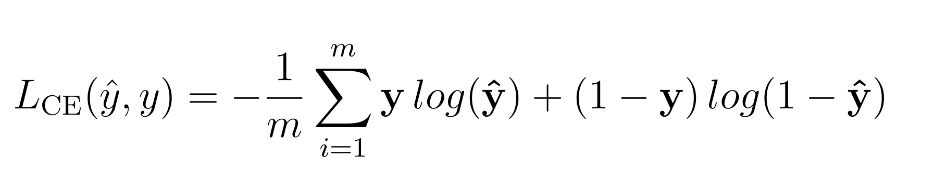

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

Prepare datasets for training and testing

In [2]:
# dataset split for dataframe
def train_test_split(X, y, test_size=0.2):
  if X.shape[0] != y.shape[0]:
    raise ValueError('X and y must have the same number of samples.')

  num_samples = X.shape[0]
  test_samples = int(num_samples * test_size)

  # Randomly shuffle before sampling
  indices = np.arange(num_samples)
  np.random.shuffle(indices)

  # Split data
  if isinstance(X, pd.DataFrame):
    X_train = X.iloc[indices[:-test_samples]]
    X_test = X.iloc[indices[-test_samples:]]
  else: # assuming X is a numpy array (features vector)
    X_train = X[indices[:-test_samples]]
    X_test = X[indices[-test_samples:]]

  if isinstance(y, pd.Series):
    y_train = y.iloc[indices[:-test_samples]]
    y_test = y.iloc[indices[-test_samples:]]
  else: # assuming y is a numpy array
    y_train = y[indices[:-test_samples]]
    y_test = y[indices[-test_samples:]]

  return X_train, X_test, y_train, y_test

In [3]:
def encode_categorical_features(X_train, X_test, categorical):
    encodings = {}

    for feature in categorical:
        # Get the unique categories in the training data
        categories = sorted(X_train[feature].unique())

        # Create a dictionary that maps each category to a unique integer
        category_to_int = {category: i for i, category in enumerate(categories)}

        # Store the encoding in a dictionary
        encodings[feature] = category_to_int

        # Transform the training data
        X_train.loc[:, feature] = X_train[feature].map(category_to_int)

        # Transform the test data using the encoding learned from the training data
        # If a category appears in the test data that was not in the training data, it is replaced with None
        X_test.loc[:, feature] = X_test[feature].map(category_to_int)

    return X_train, X_test, encodings

In [4]:
def normalize_features(X_train, X_test):
  '''
  Normalize the features (each columns) individually.
  After this, each column should have mean = 0 and standard deviation = 1.
  '''
  mean = X_train.mean()
  std = X_train.std()
  std[std == 0] = 1e-8 # replace 0 with very small number to avoid division by zero error

  X_train_normalized = (X_train - mean) / std

  # Use statistic of the train set to normalize for both dataset
  X_test_normalized = (X_test - mean) / std

  return X_train_normalized.values, X_test_normalized.values

In [5]:
def prepare_data(filepath='adult.csv'):
  df = pd.read_csv(filepath)

  # replace '?' value in the dataframe with nan
  df[df == '?'] = np.nan

  # deal with missing data: fill with mode value
  columns_with_na = df.columns[df.isna().any()].tolist()
  for col in columns_with_na:
    df[col].fillna(df[col].mode()[0], inplace=True)

  # df = df[:10000]

  # Shuffle the dataset
  df = df.sample(frac=1).reset_index(drop=True)

  # separate features and label
  X = df.drop(['income'], axis=1)
  y = df['income']

  # split train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # encode categorical features to number
  categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
  X_train, X_test, encodings = encode_categorical_features(X_train, X_test, categorical)

  # normalize features values
  X_train, X_test = normalize_features(X_train, X_test)

  # encode labels
  label_map = {'<=50K': 0, '>50K': 1}
  y_train = y_train.map(label_map)
  y_test = y_test.map(label_map)

  # reshape label array
  y_train = y_train.values.reshape(y_train.shape[0], )
  y_test = y_test.values.reshape(y_test.shape[0], )

  return X_train, X_test, y_train, y_test

Implement functions: Logistic Regression  
with Binary Cross Entropy Loss (Log loss)  
Update with gradient descent as partial derivative of binary cross entropy

Init weights and bias

In [6]:
def init_params(x):
  weights = np.zeros(x.shape[1])
  bias = 0
  return weights, bias

Logistic function: Sigmoid

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
def predict(X, weights, bias):
    z = np.array(np.dot(X, weights) + bias, dtype=np.float64)
    return sigmoid(z)

Loss function: Binary Cross Entropy  
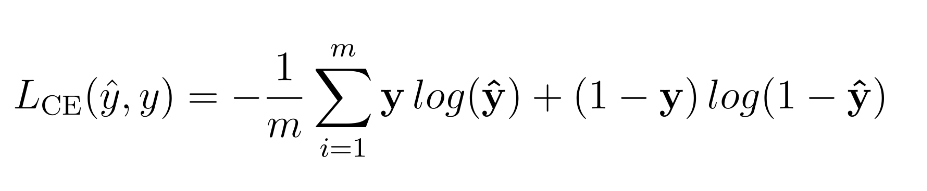

In [9]:
def BCE_loss(y_true, y_hat):
  # return -np.mean(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))
  epsilon = 1e-8
  loss_1 = y_true * np.log(y_hat + epsilon)
  loss_2 = (1 - y_true) * np.log(1 - y_hat + epsilon)
  loss = -np.mean(loss_1 + loss_2)
  return loss

Gradient function: calc gradient for weights and bias
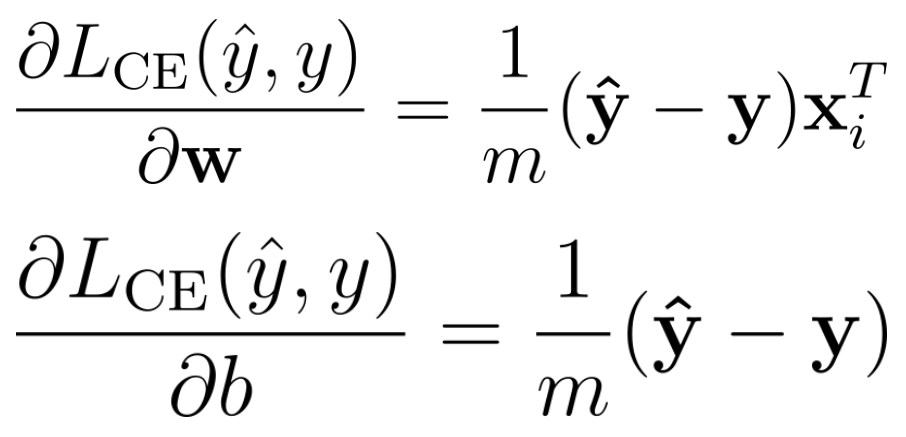

In [10]:
def compute_gradient(x, y_true, y_hat):
  grad_w = np.array(np.dot(x.T, y_hat - y_true) / np.shape(y_true)[0])
  grad_b = np.mean(y_hat - y_true)
  return grad_w, grad_b

In [11]:
def update_params_with_gradient(w, b, dw, db, lr=0.001):
  w = w - lr * dw
  b = b - lr * db
  return w, b

Mini-batch preparation

In [12]:
def prepare_batches(x, y, batch_size=32):
  x_batch_list = list()
  y_batch_list = list()

  for i in range(len(y) // batch_size):
    x_batch_list.append(x[i * batch_size : i * batch_size + batch_size, :])
    y_batch_list.append(y[i * batch_size : i * batch_size + batch_size])

  if len(y) % batch_size > 0:
    x_batch_list.append(x[len(y) // batch_size * batch_size : , :])
    y_batch_list.append(y[len(y) // batch_size * batch_size :])

  return x_batch_list, y_batch_list

Train (fit) function - using mini-batch gradient descent update

In [13]:
def LR_fit(X_train, y_train, batch_size=32, patience=3, lr=0.001, epochs=100):
  # split train data into train and validation set
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

  train_losses = []
  val_losses = []
  val_accs = []

  # prepare for mini-batch implementation
  X_batches, y_batches = prepare_batches(X_train, y_train, batch_size=batch_size)
  n_batches = len(y_batches)

  # prepare for early stopping
  patience_counter = 0
  epochs_without_improvement = 0

  # random init weights and bias
  weights, bias = init_params(X_train) # weights has shape = (number of features, )
  # prepare for weights and bias update; record val loss
  best_weights = None
  best_bias = None
  best_val_loss = float('inf')

  for epoch in tqdm(range(epochs)):
    for i in range(n_batches):
      x = X_batches[i]
      y = y_batches[i]

      y_hat = predict(x, weights, bias) # y_hat shape = (number of train data points, ) (same as y_train)

      loss = BCE_loss(y, y_hat)
      train_losses.append(loss)

      # calc gradient
      dw, db = compute_gradient(x, y, y_hat)
      # update weights and bias
      weights, bias = update_params_with_gradient(weights, bias, dw, db)

    # validation for each epoch
    y_val_hat = predict(X_val, weights, bias)
    y_val_hat_labels = np.round(y_val_hat)
    val_loss = BCE_loss(y_val, y_val_hat)
    val_losses.append(val_loss)
    val_acc = np.mean(y_val_hat_labels == y_val)
    val_accs.append(val_acc)

    print('Epoch {} | train loss={:.3f} | val loss={:.3f} | val accuracy={:.3f}'.format(epoch, loss, val_loss, val_acc))

    # early stopping check
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_weights = weights.copy()
      best_bias = bias
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
      print('Early stopping at epoch {}'.format(epoch))
      break

  return best_weights, best_bias, train_losses, val_losses, val_accs

Main program: Logistic Regression

In [14]:
epochs = 100

# hyper-parameters

batch_size = 64
# learning rate
lr = 0.01
# wait count for early stopping
patience = 5

In [15]:
X_train, X_test, y_train, y_test = prepare_data()

In [16]:
w, b, train_losses, val_losses, val_accs = LR_fit(X_train, y_train,
                      batch_size=batch_size,
                      patience=patience,
                      lr=lr,
                      epochs=epochs)

  1%|          | 1/100 [00:00<00:20,  4.76it/s]

Epoch 0 | train loss=0.655 | val loss=0.652 | val accuracy=0.801


  3%|▎         | 3/100 [00:00<00:20,  4.66it/s]

Epoch 1 | train loss=0.626 | val loss=0.620 | val accuracy=0.802
Epoch 2 | train loss=0.603 | val loss=0.593 | val accuracy=0.803


  5%|▌         | 5/100 [00:01<00:18,  5.07it/s]

Epoch 3 | train loss=0.584 | val loss=0.572 | val accuracy=0.805
Epoch 4 | train loss=0.569 | val loss=0.554 | val accuracy=0.807


  7%|▋         | 7/100 [00:01<00:14,  6.50it/s]

Epoch 5 | train loss=0.557 | val loss=0.538 | val accuracy=0.808
Epoch 6 | train loss=0.546 | val loss=0.525 | val accuracy=0.808


  9%|▉         | 9/100 [00:01<00:14,  6.37it/s]

Epoch 7 | train loss=0.537 | val loss=0.514 | val accuracy=0.807
Epoch 8 | train loss=0.530 | val loss=0.504 | val accuracy=0.808


 10%|█         | 10/100 [00:01<00:15,  5.74it/s]

Epoch 9 | train loss=0.523 | val loss=0.496 | val accuracy=0.809


 12%|█▏        | 12/100 [00:02<00:16,  5.43it/s]

Epoch 10 | train loss=0.517 | val loss=0.488 | val accuracy=0.810
Epoch 11 | train loss=0.512 | val loss=0.481 | val accuracy=0.809


 14%|█▍        | 14/100 [00:02<00:14,  5.78it/s]

Epoch 12 | train loss=0.508 | val loss=0.475 | val accuracy=0.810
Epoch 13 | train loss=0.504 | val loss=0.470 | val accuracy=0.810


 16%|█▌        | 16/100 [00:02<00:12,  6.81it/s]

Epoch 14 | train loss=0.501 | val loss=0.465 | val accuracy=0.810
Epoch 15 | train loss=0.498 | val loss=0.461 | val accuracy=0.809


 18%|█▊        | 18/100 [00:03<00:11,  7.14it/s]

Epoch 16 | train loss=0.495 | val loss=0.457 | val accuracy=0.809
Epoch 17 | train loss=0.493 | val loss=0.454 | val accuracy=0.808


 20%|██        | 20/100 [00:03<00:10,  7.44it/s]

Epoch 18 | train loss=0.491 | val loss=0.450 | val accuracy=0.809
Epoch 19 | train loss=0.489 | val loss=0.447 | val accuracy=0.809


 22%|██▏       | 22/100 [00:03<00:09,  8.58it/s]

Epoch 20 | train loss=0.488 | val loss=0.445 | val accuracy=0.809
Epoch 21 | train loss=0.487 | val loss=0.442 | val accuracy=0.808
Epoch 22 | train loss=0.485 | val loss=0.440 | val accuracy=0.808


 25%|██▌       | 25/100 [00:03<00:08,  9.22it/s]

Epoch 23 | train loss=0.484 | val loss=0.438 | val accuracy=0.809
Epoch 24 | train loss=0.483 | val loss=0.436 | val accuracy=0.809


 28%|██▊       | 28/100 [00:04<00:07,  9.27it/s]

Epoch 25 | train loss=0.483 | val loss=0.434 | val accuracy=0.809
Epoch 26 | train loss=0.482 | val loss=0.432 | val accuracy=0.809
Epoch 27 | train loss=0.481 | val loss=0.431 | val accuracy=0.809


 29%|██▉       | 29/100 [00:04<00:07,  8.93it/s]

Epoch 28 | train loss=0.481 | val loss=0.429 | val accuracy=0.809
Epoch 29 | train loss=0.480 | val loss=0.428 | val accuracy=0.809


 32%|███▏      | 32/100 [00:04<00:08,  8.13it/s]

Epoch 30 | train loss=0.480 | val loss=0.427 | val accuracy=0.809
Epoch 31 | train loss=0.480 | val loss=0.426 | val accuracy=0.809


 34%|███▍      | 34/100 [00:04<00:09,  7.17it/s]

Epoch 32 | train loss=0.480 | val loss=0.425 | val accuracy=0.809
Epoch 33 | train loss=0.479 | val loss=0.424 | val accuracy=0.809


 35%|███▌      | 35/100 [00:05<00:11,  5.78it/s]

Epoch 34 | train loss=0.479 | val loss=0.423 | val accuracy=0.809


 36%|███▌      | 36/100 [00:05<00:12,  5.08it/s]

Epoch 35 | train loss=0.479 | val loss=0.422 | val accuracy=0.809


 37%|███▋      | 37/100 [00:05<00:12,  4.87it/s]

Epoch 36 | train loss=0.479 | val loss=0.421 | val accuracy=0.809


 39%|███▉      | 39/100 [00:06<00:12,  5.03it/s]

Epoch 37 | train loss=0.479 | val loss=0.420 | val accuracy=0.810
Epoch 38 | train loss=0.479 | val loss=0.419 | val accuracy=0.810


 41%|████      | 41/100 [00:06<00:11,  5.18it/s]

Epoch 39 | train loss=0.479 | val loss=0.418 | val accuracy=0.810
Epoch 40 | train loss=0.479 | val loss=0.418 | val accuracy=0.810


 42%|████▏     | 42/100 [00:06<00:13,  4.33it/s]

Epoch 41 | train loss=0.479 | val loss=0.417 | val accuracy=0.810


 43%|████▎     | 43/100 [00:07<00:15,  3.73it/s]

Epoch 42 | train loss=0.479 | val loss=0.416 | val accuracy=0.810


 44%|████▍     | 44/100 [00:07<00:15,  3.68it/s]

Epoch 43 | train loss=0.480 | val loss=0.416 | val accuracy=0.810


 45%|████▌     | 45/100 [00:07<00:17,  3.19it/s]

Epoch 44 | train loss=0.480 | val loss=0.415 | val accuracy=0.810


 46%|████▌     | 46/100 [00:08<00:16,  3.22it/s]

Epoch 45 | train loss=0.480 | val loss=0.415 | val accuracy=0.810


 47%|████▋     | 47/100 [00:08<00:16,  3.27it/s]

Epoch 46 | train loss=0.480 | val loss=0.414 | val accuracy=0.810


 48%|████▊     | 48/100 [00:08<00:16,  3.18it/s]

Epoch 47 | train loss=0.480 | val loss=0.414 | val accuracy=0.810


 49%|████▉     | 49/100 [00:08<00:14,  3.48it/s]

Epoch 48 | train loss=0.480 | val loss=0.413 | val accuracy=0.810


 50%|█████     | 50/100 [00:09<00:13,  3.67it/s]

Epoch 49 | train loss=0.481 | val loss=0.413 | val accuracy=0.810


 51%|█████     | 51/100 [00:09<00:12,  3.81it/s]

Epoch 50 | train loss=0.481 | val loss=0.412 | val accuracy=0.810


 52%|█████▏    | 52/100 [00:09<00:12,  3.77it/s]

Epoch 51 | train loss=0.481 | val loss=0.412 | val accuracy=0.810


 53%|█████▎    | 53/100 [00:09<00:12,  3.83it/s]

Epoch 52 | train loss=0.481 | val loss=0.412 | val accuracy=0.810


 54%|█████▍    | 54/100 [00:10<00:11,  3.90it/s]

Epoch 53 | train loss=0.481 | val loss=0.411 | val accuracy=0.810


 55%|█████▌    | 55/100 [00:10<00:10,  4.09it/s]

Epoch 54 | train loss=0.482 | val loss=0.411 | val accuracy=0.810


 56%|█████▌    | 56/100 [00:10<00:11,  3.83it/s]

Epoch 55 | train loss=0.482 | val loss=0.410 | val accuracy=0.810


 57%|█████▋    | 57/100 [00:11<00:12,  3.45it/s]

Epoch 56 | train loss=0.482 | val loss=0.410 | val accuracy=0.810


 58%|█████▊    | 58/100 [00:11<00:14,  2.86it/s]

Epoch 57 | train loss=0.482 | val loss=0.410 | val accuracy=0.810


 59%|█████▉    | 59/100 [00:12<00:15,  2.59it/s]

Epoch 58 | train loss=0.483 | val loss=0.410 | val accuracy=0.810


 60%|██████    | 60/100 [00:12<00:16,  2.45it/s]

Epoch 59 | train loss=0.483 | val loss=0.409 | val accuracy=0.810


 61%|██████    | 61/100 [00:13<00:16,  2.32it/s]

Epoch 60 | train loss=0.483 | val loss=0.409 | val accuracy=0.810


 62%|██████▏   | 62/100 [00:13<00:17,  2.16it/s]

Epoch 61 | train loss=0.483 | val loss=0.409 | val accuracy=0.810


 63%|██████▎   | 63/100 [00:14<00:18,  1.97it/s]

Epoch 62 | train loss=0.484 | val loss=0.408 | val accuracy=0.810


 64%|██████▍   | 64/100 [00:14<00:20,  1.72it/s]

Epoch 63 | train loss=0.484 | val loss=0.408 | val accuracy=0.810


 65%|██████▌   | 65/100 [00:15<00:20,  1.67it/s]

Epoch 64 | train loss=0.484 | val loss=0.408 | val accuracy=0.810


 66%|██████▌   | 66/100 [00:15<00:17,  1.94it/s]

Epoch 65 | train loss=0.484 | val loss=0.408 | val accuracy=0.810


 67%|██████▋   | 67/100 [00:16<00:13,  2.36it/s]

Epoch 66 | train loss=0.485 | val loss=0.407 | val accuracy=0.810


 68%|██████▊   | 68/100 [00:16<00:13,  2.36it/s]

Epoch 67 | train loss=0.485 | val loss=0.407 | val accuracy=0.810


 69%|██████▉   | 69/100 [00:16<00:12,  2.56it/s]

Epoch 68 | train loss=0.485 | val loss=0.407 | val accuracy=0.810


 70%|███████   | 70/100 [00:17<00:10,  2.83it/s]

Epoch 69 | train loss=0.485 | val loss=0.407 | val accuracy=0.810


 72%|███████▏  | 72/100 [00:17<00:08,  3.33it/s]

Epoch 70 | train loss=0.485 | val loss=0.407 | val accuracy=0.810
Epoch 71 | train loss=0.486 | val loss=0.406 | val accuracy=0.810


 73%|███████▎  | 73/100 [00:17<00:07,  3.48it/s]

Epoch 72 | train loss=0.486 | val loss=0.406 | val accuracy=0.810


 74%|███████▍  | 74/100 [00:18<00:06,  3.74it/s]

Epoch 73 | train loss=0.486 | val loss=0.406 | val accuracy=0.811


 75%|███████▌  | 75/100 [00:18<00:07,  3.55it/s]

Epoch 74 | train loss=0.486 | val loss=0.406 | val accuracy=0.811


 76%|███████▌  | 76/100 [00:18<00:06,  3.57it/s]

Epoch 75 | train loss=0.487 | val loss=0.406 | val accuracy=0.811


 77%|███████▋  | 77/100 [00:18<00:06,  3.65it/s]

Epoch 76 | train loss=0.487 | val loss=0.405 | val accuracy=0.811


 78%|███████▊  | 78/100 [00:19<00:05,  3.68it/s]

Epoch 77 | train loss=0.487 | val loss=0.405 | val accuracy=0.811


 79%|███████▉  | 79/100 [00:19<00:06,  3.23it/s]

Epoch 78 | train loss=0.487 | val loss=0.405 | val accuracy=0.811


 80%|████████  | 80/100 [00:20<00:06,  2.86it/s]

Epoch 79 | train loss=0.487 | val loss=0.405 | val accuracy=0.811


 81%|████████  | 81/100 [00:20<00:06,  2.93it/s]

Epoch 80 | train loss=0.488 | val loss=0.405 | val accuracy=0.811


 82%|████████▏ | 82/100 [00:20<00:05,  3.25it/s]

Epoch 81 | train loss=0.488 | val loss=0.405 | val accuracy=0.811


 83%|████████▎ | 83/100 [00:20<00:05,  3.21it/s]

Epoch 82 | train loss=0.488 | val loss=0.404 | val accuracy=0.811


 84%|████████▍ | 84/100 [00:21<00:05,  3.11it/s]

Epoch 83 | train loss=0.488 | val loss=0.404 | val accuracy=0.811


 85%|████████▌ | 85/100 [00:21<00:05,  2.81it/s]

Epoch 84 | train loss=0.488 | val loss=0.404 | val accuracy=0.811


 86%|████████▌ | 86/100 [00:21<00:04,  3.13it/s]

Epoch 85 | train loss=0.489 | val loss=0.404 | val accuracy=0.811


 87%|████████▋ | 87/100 [00:22<00:03,  3.38it/s]

Epoch 86 | train loss=0.489 | val loss=0.404 | val accuracy=0.811


 88%|████████▊ | 88/100 [00:22<00:03,  3.45it/s]

Epoch 87 | train loss=0.489 | val loss=0.404 | val accuracy=0.811


 89%|████████▉ | 89/100 [00:22<00:02,  3.71it/s]

Epoch 88 | train loss=0.489 | val loss=0.404 | val accuracy=0.811


 90%|█████████ | 90/100 [00:22<00:02,  3.94it/s]

Epoch 89 | train loss=0.489 | val loss=0.403 | val accuracy=0.811


 91%|█████████ | 91/100 [00:23<00:02,  4.00it/s]

Epoch 90 | train loss=0.489 | val loss=0.403 | val accuracy=0.811


 92%|█████████▏| 92/100 [00:23<00:02,  3.68it/s]

Epoch 91 | train loss=0.490 | val loss=0.403 | val accuracy=0.811


 93%|█████████▎| 93/100 [00:23<00:02,  3.31it/s]

Epoch 92 | train loss=0.490 | val loss=0.403 | val accuracy=0.811


 94%|█████████▍| 94/100 [00:24<00:01,  3.04it/s]

Epoch 93 | train loss=0.490 | val loss=0.403 | val accuracy=0.811


 95%|█████████▌| 95/100 [00:24<00:01,  3.13it/s]

Epoch 94 | train loss=0.490 | val loss=0.403 | val accuracy=0.811


 96%|█████████▌| 96/100 [00:24<00:01,  3.29it/s]

Epoch 95 | train loss=0.490 | val loss=0.403 | val accuracy=0.812


 97%|█████████▋| 97/100 [00:25<00:00,  3.33it/s]

Epoch 96 | train loss=0.490 | val loss=0.403 | val accuracy=0.812


 98%|█████████▊| 98/100 [00:25<00:00,  3.20it/s]

Epoch 97 | train loss=0.490 | val loss=0.403 | val accuracy=0.812


 99%|█████████▉| 99/100 [00:25<00:00,  2.79it/s]

Epoch 98 | train loss=0.491 | val loss=0.402 | val accuracy=0.812


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]

Epoch 99 | train loss=0.491 | val loss=0.402 | val accuracy=0.812


In [17]:
print('Weights: ', w)
print('Bias: ', b)

Weights:  [0.43372776207981706 -0.07773252488698558 0.038623423787354894
 0.036482852459654436 0.7748915571270357 -0.2995574092811833
 -0.0060382530404030944 -0.26219153589064786 0.08882839596037707
 0.3328091378753154 0.8344941760541223 0.24861432133758019
 0.3539633098188351 0.019784225658655043]
Bias:  -1.512092748155759


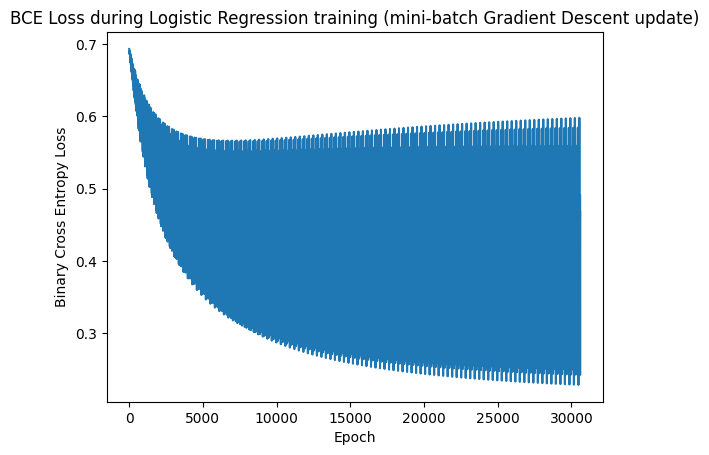

In [18]:
# Plot loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.title('BCE Loss during Logistic Regression training (mini-batch Gradient Descent update)')
plt.show()

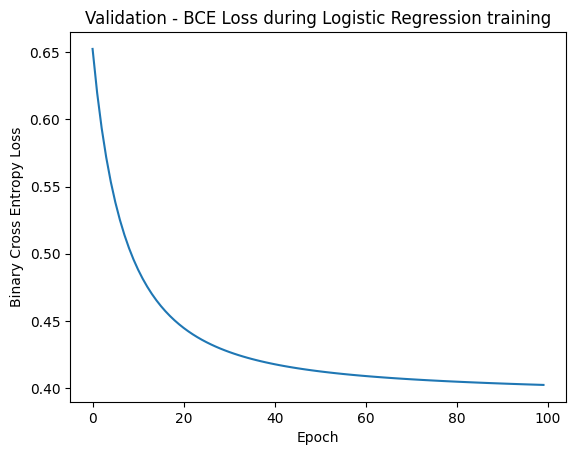

In [19]:
# Plot loss
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.title('Validation - BCE Loss during Logistic Regression training')
plt.show()

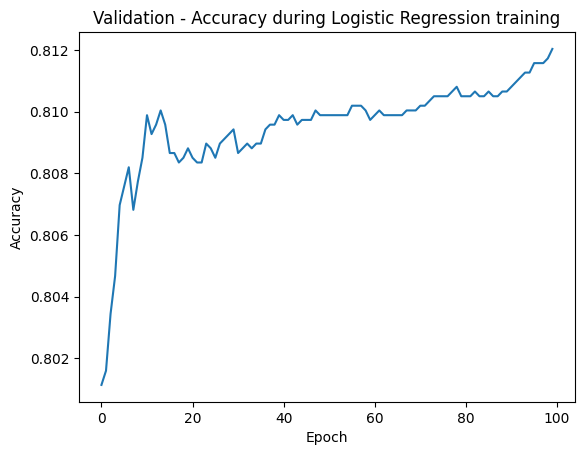

In [20]:
# Plot loss
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation - Accuracy during Logistic Regression training')
plt.show()

Evaluate model

In [21]:
def evaluate_model(X_test, y_test, weights, bias):
    """Evaluate the logistic regression model"""
    y_pred = predict(X_test, weights, bias)
    y_pred_labels = np.round(y_pred)

    # Confusion matrix
    TP = np.sum((y_pred_labels == 1) & (y_test == 1))
    TN = np.sum((y_pred_labels == 0) & (y_test == 0))
    FP = np.sum((y_pred_labels == 1) & (y_test == 0))
    FN = np.sum((y_pred_labels == 0) & (y_test == 1))

    confusion_matrix = np.array([[TN, FP], [FN, TP]])

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return confusion_matrix, accuracy, precision, recall, specificity

In [22]:
confusion_matrix, accuracy, precision, recall, specificity = evaluate_model(X_test, y_test, w, b)

print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)

Confusion Matrix:
[[4700  262]
 [ 901  649]]
Accuracy: 0.8214066339066339
Precision: 0.712403951701427
Recall: 0.41870967741935483
Specificity: 0.947198710197501


Compare with model from library

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.metrics import specificity_score

# Create a logistic regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)
# Get the weights (coefficients)
lib_weights = model.coef_
# Get the bias (intercept)
lib_bias = model.intercept_

# Get the predicted labels for the test set
lib_y_pred = model.predict(X_test)

# Compute the confusion matrix
lib_cm = confusion_matrix(y_test, lib_y_pred)
# Compute the accuracy
lib_accuracy = accuracy_score(y_test, lib_y_pred)
# Compute the precision
lib_precision = precision_score(y_test, lib_y_pred)
# Compute the recall
lib_recall = recall_score(y_test, lib_y_pred)
# Compute the specificity score
lib_specificity = specificity_score(y_test, lib_y_pred)

print("Confusion Matrix:")
print(lib_cm)
print("Accuracy:", lib_accuracy)
print("Precision:", lib_precision)
print("Recall:", lib_recall)
print("Specificity:", lib_specificity)

Confusion Matrix:
[[4678  284]
 [ 864  686]]
Accuracy: 0.8237100737100738
Precision: 0.7072164948453609
Recall: 0.4425806451612903
Specificity: 0.9427650141072148


SIMILAR RESULT!